#Importing packages

In [ ]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import os
import cv2
import csv
import copy
import shutil
import math
import random
import PIL

from collections import Counter
from PIL import Image
from random import sample, choices
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.image as mpimg
# %matplotlib inline  # Uncomment this if you are using Jupyter notebook
matplotlib.style.use("ggplot")

import tensorflow as tf
from tensorflow import keras

import tensorflow.keras.preprocessing.image
from tensorflow.keras import regularizers
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Lambda, Reshape, Dense, Dropout, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
# from tensorflow.keras.utils import np_utils  # Removed this line as np_utils is not available in tensorflow.keras.utils
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Input, optimizers, layers, models, callbacks, applications
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from skimage.transform import resize
from IPython.display import SVG

To incorporate the dataset into Google Colab's runtime files, given its large size, we need to import it from Google Drive. Initially, we connect to Google Drive by mounting it:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Descriptive Analysis

The CUB-200-2011 dataset, an extension of the original CUB-200 dataset, offers approximately twice as many images per category along with novel part location annotations. For comprehensive insights into the dataset, please refer to the associated technical report.

Number of categories: 200

Number of images: 11,788

Annotations per image: 15 Part Locations, 312 Binary Attributes, 1 Bounding Box

Prior to analyzing the images and their characteristics, it's necessary to import the dataset from Google Drive.

In [ ]:
#Upload the directory containing all the images, previously referred to as train_root

image_folder = '/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images'

#Upload a text file containing the names of each image in the dataset
#This file will serve as the reference to locate the images
path_txt = '/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images.txt'

In [ ]:
#Create a pathway to the list of images along with their corresponding class labels
img_label_txt = '/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/image_class_labels.txt'

#Create an empty array ready to input number of images per class
label_list = []

#Open the class label assignments text file
fp = open(img_label_txt)

#Use a for loop to transfer the classes to the array
for line in fp:
    #extract the image number and class label
    idx, label = line.strip().split()
    #append empty array with class label only
    label_list.append(int(label) - 1)

#Close the text file so it doesn't get altered
fp.close()

##Examining the images

Let's take a glance at some of the images:

A small sample of unprocessed images:


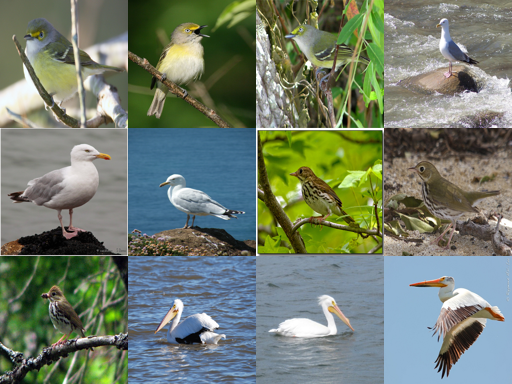

In [ ]:
# Define the layout of the grid for displaying images
n_col = 4 # The grid will have 4 columns
n_row = 3 # The grid will have 3 rows
n_spec = 3 # We will display 3 images from each randomly selected class
img_h = 128 # All images will be resized to have a height of 128 pixels
img_w = 128 # All images will be resized to have a width of 128 pixels

# Initialize a list to store the paths of all images
img_path_list = []

# Open the text file that contains the image paths
fp = open(path_txt)

# Read each line in the text file
for line in fp:
  # Split the line into index and path
  idx, img_path = line.strip().split()
  # Construct the full path of the image and add it to the list
  img_path_list.append(os.path.join(image_folder, img_path))

# Close the text file
fp.close()

# Initialize a list of lists to store the indices of images for each class
label_idx_list = [[] for i in range(200)] # There are 200 classes

# Assign each image to its corresponding class
for idx in range(len(label_list)):
    label = label_list[idx]
    label_idx_list[label].append(idx)

# Calculate the number of classes to randomly select
n_pre_spec = n_col*n_row//n_spec
# Randomly select some classes
pre_spec_list = sample(range(200), n_pre_spec)

# Initialize a list to store the paths of the selected images
path_list = []

# For each selected class, randomly select some images
for label in pre_spec_list:
    sampled_idx = sample(label_idx_list[label], n_spec)
    for idx in sampled_idx:
        path_list.append(img_path_list[idx])

# Initialize a list to store the selected images
imgs = []

# Print a message to indicate that the images are being loaded
print("A small sample of unprocessed images:")
# Load and resize each selected image
for idx in range(n_col*n_row):
    img = Image.open(path_list[idx])
    img = img.resize((128,128))
    imgs.append(img)

# Create a new image to display the grid of images
target = Image.new('RGB', (img_w * n_col, img_h * n_row))
# Paste each image into the grid
for r in range(n_row):
    for c in range(n_col):
        target.paste(imgs[n_col*r+c], (0 + img_w*c, 0 + img_h*r))

# Display the grid of images
display(target)
# Save the grid of images as a JPEG file
save_name = 'overview.jpg'
target.save(save_name, quality=100)


We can also look at samples of birds from particular classes:


In [ ]:
# Define a function to display a grid of random sample images from a specified class
def BirdView(genera):
  # Print the class name
  print("Displaying sample images for class: " + genera)

  # Specify the root directory where the images are stored
  root_path='/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images'

  # Construct the path to the images of the specified class
  img_path=os.path.join(root_path, genera, '**')

  # Get a list of all image paths in the specified class
  images = glob.glob(img_path)

  # Create a figure to display the images
  plt.figure(figsize=(16,16))

  # Randomly select 10 images from the list
  img=random.sample(images,10)

  # Display each selected image in a subplot
  plt.subplot(131)
  plt.imshow(cv2.imread(img[0]))
  plt.subplot(132)
  plt.imshow(cv2.imread(img[1]))
  plt.subplot(133)
  plt.imshow(cv2.imread(img[2]))

  # Return from the function
  return


Sample of Black-footed Albatross:
Samples images for Bird 001.Black_footed_Albatross


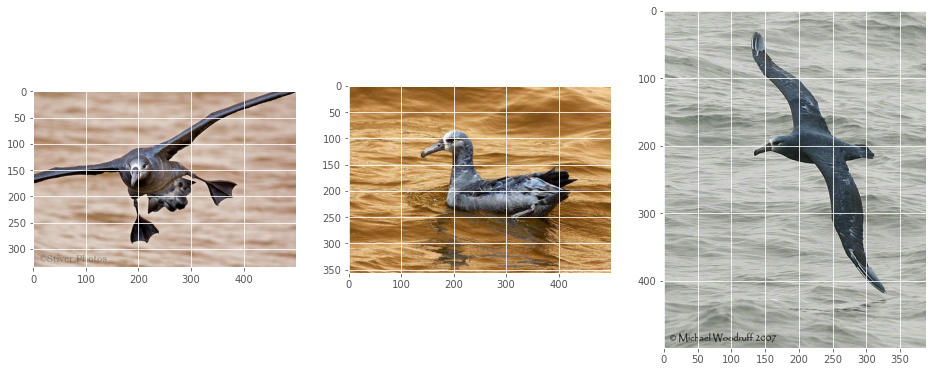

In [ ]:
#Test the function to see if it works
print('Sample of Black-footed Albatross:')
BirdView('001.Black_footed_Albatross')

##Overall Statistical Properties

Next, we'll examine the dataset's general properties, beginning with the number of images in each class. To do this, we'll upload the classes text file from the dataset and convert it into a dictionary format:

In [ ]:
# Initialize an empty dictionary to store the class names
labels_dict={}

# Open the text file that contains the class names in read-only mode
f = open('/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/classes.txt', 'r')

# Iterate over each line in the text file
for line in f:
    # Split the line into class number (value) and class name (key)
    value, key = line.split(' ')
    # Add the class name and number to the dictionary
    # Note: The [:-1] is used to remove the newline character at the end of the class name
    labels_dict[key[:-1]] = int(value)

# Close the text file after reading all lines
f.close()

# Print the dictionary to verify that it was created correctly
print("The dictionary of class names is:")
print(labels_dict)

The dictionary of class names is:
{'001.Black_footed_Albatross': 1, '002.Laysan_Albatross': 2, '003.Sooty_Albatross': 3, '004.Groove_billed_Ani': 4, '005.Crested_Auklet': 5, '006.Least_Auklet': 6, '007.Parakeet_Auklet': 7, '008.Rhinoceros_Auklet': 8, '009.Brewer_Blackbird': 9, '010.Red_winged_Blackbird': 10, '011.Rusty_Blackbird': 11, '012.Yellow_headed_Blackbird': 12, '013.Bobolink': 13, '014.Indigo_Bunting': 14, '015.Lazuli_Bunting': 15, '016.Painted_Bunting': 16, '017.Cardinal': 17, '018.Spotted_Catbird': 18, '019.Gray_Catbird': 19, '020.Yellow_breasted_Chat': 20, '021.Eastern_Towhee': 21, '022.Chuck_will_Widow': 22, '023.Brandt_Cormorant': 23, '024.Red_faced_Cormorant': 24, '025.Pelagic_Cormorant': 25, '026.Bronzed_Cowbird': 26, '027.Shiny_Cowbird': 27, '028.Brown_Creeper': 28, '029.American_Crow': 29, '030.Fish_Crow': 30, '031.Black_billed_Cuckoo': 31, '032.Mangrove_Cuckoo': 32, '033.Yellow_billed_Cuckoo': 33, '034.Gray_crowned_Rosy_Finch': 34, '035.Purple_Finch': 35, '036.Norther

Now that we have the dictionary of classes, we can have a look at some of the global properties of the dataset. First, we look at the statistical values in each class:

In [ ]:
# Assuming that `label_list` is a list of labels where each label corresponds to a class of an image

from collections import Counter
import statistics

# Use Counter to count the number of images in each class
counter = Counter(label_list)

# Convert the counts to a list
counts = list(counter.values())

# Calculate statistical properties
mean = statistics.mean(counts)
median = statistics.median(counts)
max_count = max(counts)
min_count = min(counts)
variance = statistics.variance(counts)
std_dev = statistics.stdev(counts)

# Print statistical properties
print(f'Mean number of images per class: {mean:.2f}')
print(f'Median number of images per class: {median:.2f}')
print(f'Maximum number of images per class: {max_count:.2f}')
print(f'Minimum number of images per class: {min_count:.2f}')
print(f'Variance of number of images per class: {variance:.2f}')
print(f'Standard deviation of number of images per class: {std_dev:.2f}')

Mean number of images per class: 58.94
Median number of images per class: 60.00
Maximum number of images per class: 60.00
Minimum number of images per class: 41.00
Variance of number of images per class: 8.52
Standard deviation of number of images per class: 2.92


The analysis indicates that the median value for the number of images per class is 60, suggesting that most classes have approximately 60 images associated with them.

The relatively low variance in the number of images per class is advantageous, as it indicates that there are no classes with sparse data. This even distribution across classes simplifies data splitting, eliminating the need for over-sampling or under-sampling techniques to address sparse class labels.

To visualize this distribution more effectively, we can plot a graph depicting the number of images in each class:

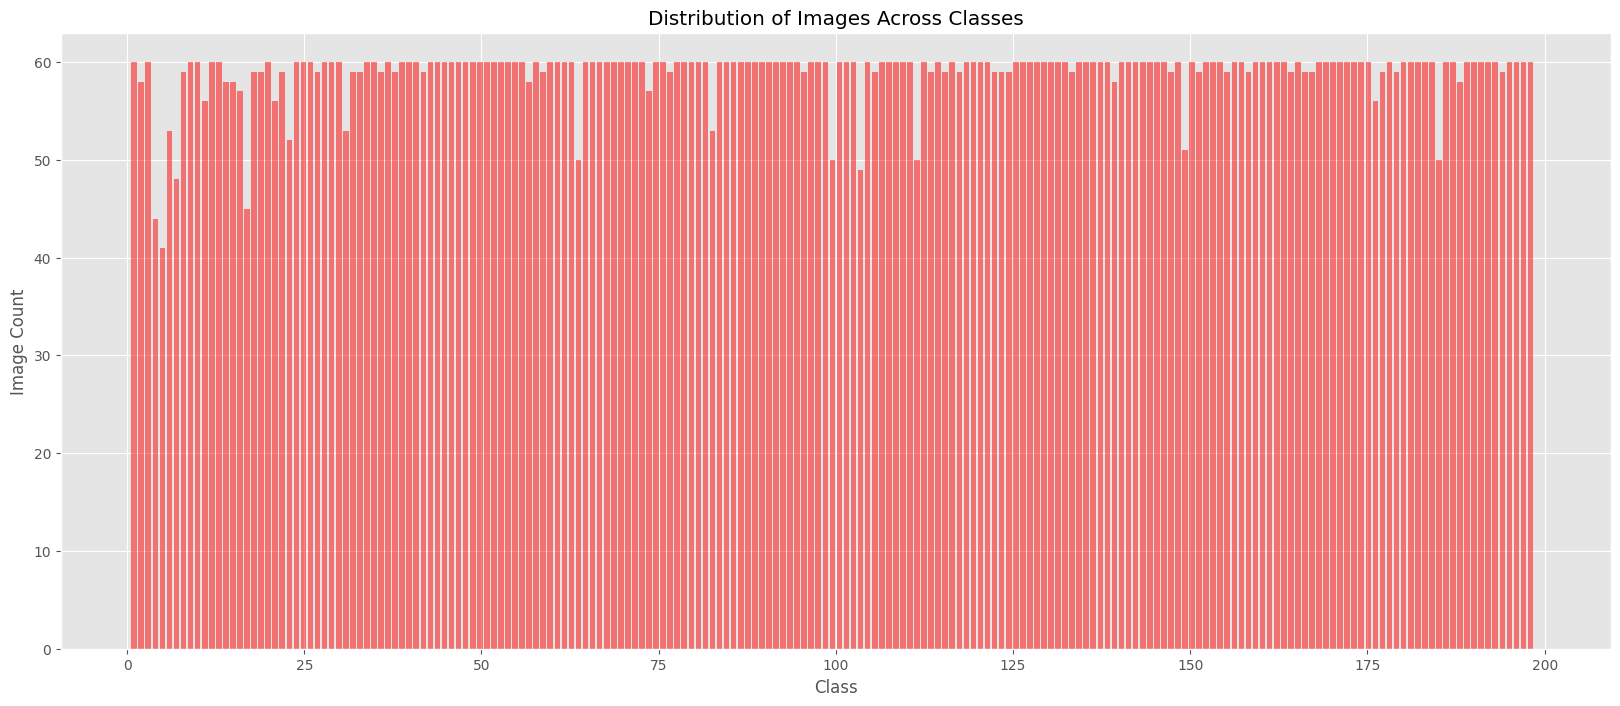

In [ ]:
# Start a new figure for the histogram
plt.figure(figsize=(20, 8))

# Convert the list of labels to a numpy array for easier manipulation
label_data = np.array(label_list)

# Create a histogram of the label data
# We use 200 bins because there are 200 classes
# The range is set to (1,200) to match the class values
# The histogram bars are aligned to the left edge of the bins
# The bars are semi-transparent (alpha=0.5) and green
plt.hist(label_data, bins=200, range=(1,200), rwidth=0.8, align='left', color="red", alpha=0.5)

# Set the labels and title of the plot
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.title("Distribution of Images Across Classes")

# Display the plot
plt.show()


The histogram illustrates that the majority of classes contain around 60 images each. The lowest number of images in a class is not sufficiently low to warrant the use of over or under-sampling techniques for compensation.

##Image Properties

Now, shifting our focus from the dataset's statistical characteristics to the properties of the individual images themselves, we'll start by examining the average image dimensions:

In [ ]:
# Initialize lists to store the dimensions of each image
h_list = [] # List for storing the height of each image
w_list = [] # List for storing the width of each image
s_list = [] # List for storing the total size (height + width) of each image

# Iterate over each image path in the list of image paths
for img_path in img_path_list:
    # Open the image file at the current path
    img = Image.open(img_path)
    # Get the dimensions of the image
    img_size = img.size
    # Add the width, height, and total size of the image to their respective lists
    w_list.append(img_size[0]) # Append the width of the image to the width list
    h_list.append(img_size[1]) # Append the height of the image to the height list
    s_list.append(img_size[0] + img_size[1]) # Append the total size of the image to the size list

In [12]:
print(f'The average image size is: {np.mean(s_list):.2f}')
print(f'The average image height is: {np.mean(h_list):.2f}')
print(f'The average image width is: {np.mean(w_list):.2f}')
print(f'The biggest image size is: {np.max(s_list):.2f}')
print(f'The smallest image size is: {np.min(s_list):.2f}')

The average image size is: 853.92
The average image height is: 386.03
The average image width is: 467.89
The biggest image size is: 1000.00
The smallest image size is: 279.00


Further analysis allows us to delve deeper into the distribution of image heights, widths, and overall sizes.

There are 335 unique image heights.


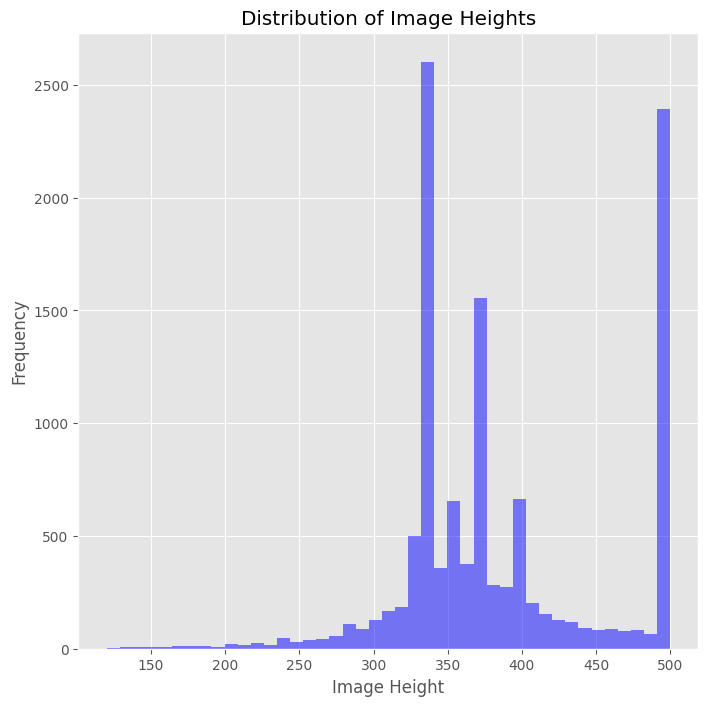

In [13]:
# Count the number of unique heights in the list of image heights
unique_heights = len(Counter(h_list))
print(f'There are {unique_heights} unique image heights.')

# Determine the number of bins for the histogram
# We divide the number of unique heights by 10 to get a manageable number of bins
num_bins = unique_heights // 10

# Create a new figure for the histogram
plt.figure(figsize=(8, 8))

# Generate the histogram of image heights
# We use the 'auto' option for the number of bins for simplicity
plt.hist(h_list, bins='auto', color='blue', alpha=0.5)

# Set the labels and title for the plot
plt.xlabel('Image Height')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights')

# Display the plot
plt.show()

The number of unique image sizes in the width array is: 283


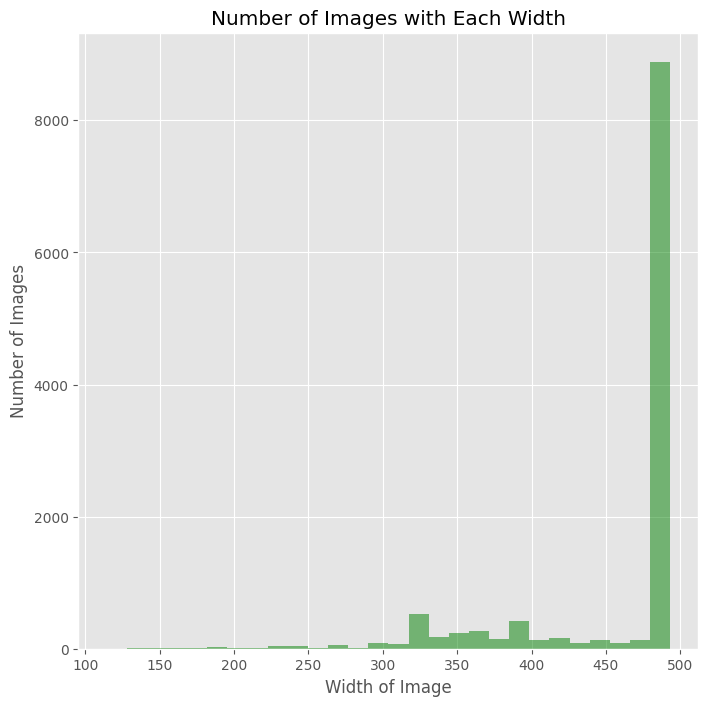

In [20]:
#Use Counter to find the number of unique image sizes in the width array
w_cnt = len(Counter(w_list))
print(f'The number of unique image sizes in the width array is: {w_cnt}')
bins_no = w_cnt//10

#Plot a histogram of the image widths
#Here we have used the number of unique image widths divided by 10,
#because 283 bins is too many to be able to see the population properties
plt.figure(figsize=(8, 8))
plt.hist(w_list, bins=bins_no, align='left', facecolor="green", edgecolor="none", alpha=0.5)
plt.xlabel("Width of Image")
plt.ylabel("Number of Images")
plt.title("Number of Images with Each Width")
plt.show()

The number of unique image sizes is: 530


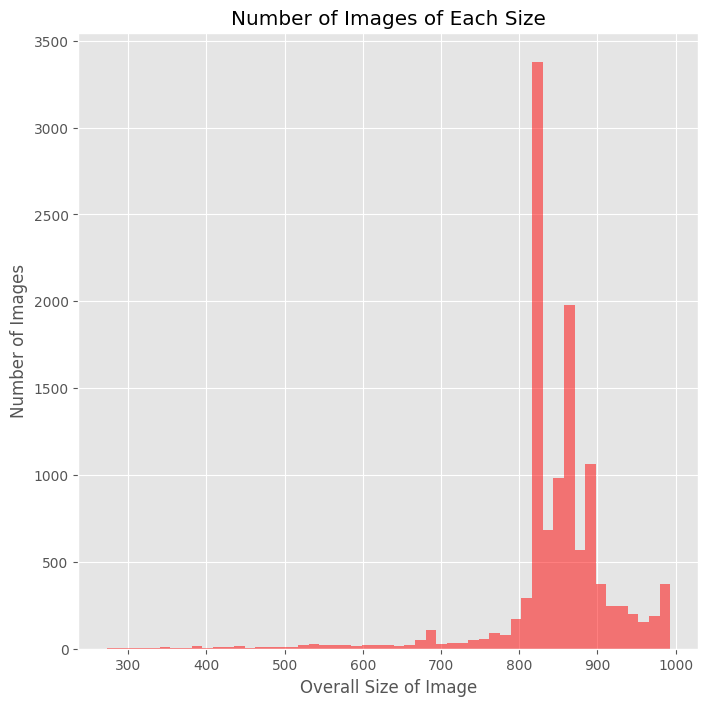

In [22]:
#Use Counter to find the number of unique image sizes in the width array
s_cnt = len(Counter(s_list))
print(f'The number of unique image sizes is: {s_cnt}')
bins_no = s_cnt//10

#Plot a histogram of the image sizes
#Here we have used the number of unique image sizes divided by 10,
#because X bins is too many to be able to see the population properties
plt.figure(figsize=(8, 8))
plt.hist(s_list, bins=bins_no, align='left', facecolor="red", edgecolor="none", alpha=0.5)
plt.xlabel("Overall Size of Image")
plt.ylabel("Number of Images")
plt.title("Number of Images of Each Size")
plt.show()

We can explore the color channels of the images, which consist of 'R' (red), 'G' (green), and 'B' (blue).

Utilizing the average image size computed earlier, we can determine the statistical characteristics of each channel. Since the images vary in size, resizing is necessary for fair comparison across channels.

Additionally, to align with the standard color scale of 0 to 1 used in common color processing libraries like Matplotlib, we need to scale down the image color values by dividing them by 255, as this dataset operates on a color scale of 0 to 255.

In [21]:
# Set the desired height and width for the images
# All images will be resized to these dimensions for consistency
img_h, img_w = 448, 448

# Initialize arrays to hold the mean and standard deviation of each color channel
means = [0, 0, 0]
stdevs = [0, 0, 0]

# Determine the total number of images by checking the length of the image path list
num_imgs = len(img_path_list)

# Loop over each image path in the list
for i in range(len(img_path_list)):
    # Load the image at the current path
    img = cv2.imread(img_path_list[i])
    # Resize the image to the desired dimensions
    img = cv2.resize(img,(img_w,img_h))
    # Convert the image data to a numpy array
    img = np.asarray(img)
    # Normalize the pixel values to the range [0, 1]
    img = img.astype(np.float32) / 255.
    # Loop over each color channel (red, green, blue)
    for c in range(3):
        # Update the mean and standard deviation for the current color channel
        means[c] += img[:, :, c].mean()
        stdevs[c] += img[:, :, c].std()
    # Print a progress update every 1000 images
    if i%1000 == 0:
        print(i,'/',num_imgs)

# Reverse the order of the means and standard deviations to match the order of the color channels
means.reverse()
stdevs.reverse()

# Convert the total means and standard deviations to averages by dividing by the number of images
means = np.asarray(means) / num_imgs
stdevs = np.asarray(stdevs) / num_imgs

# Print the average mean and standard deviation for each color channel
print('Color Channels: Red, Green, Blue')
print("Average Mean = {}".format(means))
print("Average Standard Deviation = {}".format(stdevs))


0 / 11788
1000 / 11788
2000 / 11788
3000 / 11788
4000 / 11788
5000 / 11788
6000 / 11788
7000 / 11788
8000 / 11788
9000 / 11788
10000 / 11788
11000 / 11788
Color Channels: Red, Green, Blue
Average Mean = [0.48544389 0.49915092 0.43130952]
Average Standard Deviation = [0.17901957 0.17794788 0.18994175]
